In [15]:

def RemovePunc(comment):
    comment = comment.replace('^\d+|\n|\t|"|==|;|:|@', '')
    comment = comment.replace('\d+', '')
    comment = comment.replace(',', '')
    comment = comment.replace('?', '')
    comment= comment.replace('!', '')
    comment = comment.replace('&', '')
    comment = comment.replace('[...]', '')
    comment = comment.replace('[....]', '')
    for c in string.punctuation:
        comment = comment.replace(c, "")
    return (comment)

def RemoveHttp(comment):
    comment = re.sub(r'(((https|http)?://)|(www.))(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F])|#)',
                     '', comment, flags=re.MULTILINE)
    return (comment)

def ConvertToLowerCase(comment):
    comment = comment.lower()
    return(comment)

def StemComment(comment,lowerCase,punc,http):
    if lowerCase:
        comment = ConvertToLowerCase(comment)
    if punc:
        comment = RemovePunc(comment)
    if http:
        comment = RemoveHttp(comment)
        
    comment=''.join([i for i in comment if not i.isdigit()])
    comment = nlp(comment)
    lemmatized = []
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            lemmatized.append(lemma)
    return " ".join(lemmatized)
    
def dataStem(Data,lowerCase,punc,http):
    Data_lemmatized = Data.apply(StemComment, lowerCase=True,punc=False,http=True)
    return Data_lemmatized

def saveInFile(x_train_lemmatized,fileName):
    filehandler = open(fileName+".p", "wb")
    pickle.dump(x_train_lemmatized, filehandler)
    filehandler.close()
    
def loadFromFile(fileName):
    file = open(fileName+".p", 'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

def sampling(data):
    clean = data.loc[np.random.choice(data[data['clean']==True].index.tolist(),size=9237)].reset_index(drop=True)
    severe_toxic = data.loc[np.random.choice(data[data['severe_toxic']==True].index.tolist(),size=6000,replace=True)].reset_index(drop=True)
    obscene = data.loc[np.random.choice(data[data['obscene']==True].index.tolist(),size=2000,replace=True)].reset_index(drop=True)
    threat = data.loc[np.random.choice(data[data['threat']==True].index.tolist(),size=6000,replace=True)].reset_index(drop=True)
    insult = data.loc[np.random.choice(data[data['insult']==True].index.tolist(),size=2300,replace=True)].reset_index(drop=True)
    identity_hate = data.loc[np.random.choice(data[data['identity_hate']==True].index.tolist(),size=6000,replace=True)].reset_index(drop=True)
    toxic = data[data['toxic']==1].reset_index(drop=True)

    sampled_train = pd.concat([clean,threat,toxic,severe_toxic,insult,identity_hate,obscene]).reset_index(drop=True)
    sampled_train = sampled_train.sample(frac=1).reset_index(drop=True)
    sampled_train['clean'] = sampled_train['clean'].astype(int)
    return sampled_train

def Translate(data):
    translator = Translator()
    translations= translator.translate(data)
    return translations.text

def TranslateTheDataSet(data):
    for index, row in data.iterrows():
        rowString=row['comment_text']
        if(len(rowString)>5000):
            rowString=row['comment_text'][:5000]
        try:
            translate = Translator()
            lang = translate.detect(rowString).lang
        except ValueError:
            continue
        if (lang != 'en'):
            try:
                transComment = Translate(rowString)
                data.at[index, 'comment_text'] = transComment
            except ValueError:
                continue
    return data



# Apply Stemming on Data

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import pickle
import re
import spacy
import en_core_web_sm


#nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])
nlp = en_core_web_sm.load()

train = pd.read_csv('New_Data\\train.csv')
test = pd.read_csv('New_Data\\test.csv')
#print(train)
train.index = train['id']
x_train = train['comment_text']
y_train = train.iloc[:, 2:]
test.index = test['id']
x_test = test['comment_text']
y_train['clean'] = 1 - y_train.sum(axis=1) >= 1
x_train2 = x_train.dropna()
x_test2 = x_test.dropna()
print('start train lemmatize')
x_train_lemmatized=dataStem(x_train2,lowerCase=True,punc=False,http=True)
print(x_train_lemmatized)
print('start test lemmatize')
x_test_lemmatized=dataStem(x_test2,lowerCase=True,punc=False,http=True)
train2=pd.concat([x_train_lemmatized,y_train], axis=1)

saveInFile(train2,'train_TestwithPunc')
saveInFile(x_test_lemmatized,'test_TestwithPunc')
print('Lemmatizing and storing done!')

start train lemmatize
id
0000997932d777bf    explanation why the edit make under -PRON- use...
000103f0d9cfb60f    d'aww ! -PRON- match this background colour -P...
000113f07ec002fd    hey man , -PRON- be really not try to edit war...
0001b41b1c6bb37e    " more i can not make any real suggestion on i...
0001d958c54c6e35    -PRON- , sir , be -PRON- hero . any chance -PR...
00025465d4725e87    " congratulation from -PRON- as well , use the...
0002bcb3da6cb337    cocksucker before -PRON- pis around on -PRON- ...
00031b1e95af7921    -PRON- vandalism to the matt shirvington artic...
00037261f536c51d    sorry if the word ' nonsense ' be offensive to...
00040093b2687caa    alignment on this subject and which be contrar...
0005300084f90edc    " fair use rationale for image : wonju.jpg tha...
00054a5e18b50dd4    bbq be a man and let discus -PRON- - maybe ove...
0005c987bdfc9d4b    hey ... what be -PRON- .. @ | talk . what be -...
0006f16e4e9f292e    before -PRON- start throw accusation and warn

# NB with 50,000 features

In [3]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

train = pickle.load(open('train_Test.p','rb'))
test = pickle.load(open('test_Test.p','rb'))
sample = pd.read_csv('sample_submission.csv')
sampled_train=sampling(train)
feature_model = TfidfVectorizer(ngram_range=(1, 4),max_features=50000)
feature_matrix = feature_model.fit_transform(sampled_train['comment_text'])
print(feature_matrix)
test_x = feature_model.transform(test)
for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    clf = MultinomialNB()
    clf.fit(feature_matrix, sampled_train[col])
    preds = clf.predict_proba(test_x)[:, 1]
    print(col)
    print(preds)
    print(sample.shape, preds.shape)
    sample[col] = preds

sample.to_csv("result0.csv", index=False)


  (2, 1208)	0.550168536241
  (2, 0)	0.575755963143
  (2, 1209)	0.604830267625
  (7, 507)	0.600881067348
  (7, 865)	0.527018888054
  (7, 511)	0.600993373122
  (9, 1208)	0.0807629536639
  (9, 0)	0.0845191048016
  (9, 1209)	0.0887871182393
  (9, 507)	0.261420587444
  (9, 865)	0.229285951573
  (9, 511)	0.261469447431
  (9, 1928)	0.173002750312
  (9, 927)	0.128358494823
  (9, 1134)	0.224917152186
  (9, 1944)	0.235741213389
  (9, 972)	0.123350035109
  (9, 526)	0.139420143773
  (9, 930)	0.128466808371
  (9, 577)	0.233344042482
  (9, 1139)	0.286499209397
  (9, 1945)	0.235741213389
  (9, 538)	0.137389506148
  (9, 973)	0.13488691332
  (9, 527)	0.139420143773
  :	:
  (46820, 1)	0.287994627975
  (46820, 1210)	0.287994627975
  (46820, 2)	0.287994627975
  (46820, 1211)	0.287994627975
  (46820, 120)	0.340715236578
  (46820, 8)	0.341352511923
  (46821, 1208)	0.17999180935
  (46821, 507)	0.19420440685
  (46821, 865)	0.170332194032
  (46821, 511)	0.19424070401
  (46821, 972)	0.274903219799
  (46821, 538

#  Decision Tree

In [39]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import pandas as pd

train = pickle.load(open('train.p','rb'))
test = pickle.load(open('test.p','rb'))
sample = pd.read_csv('sample_submission.csv')
#sampled_train=sampling(train)
feature_model = TfidfVectorizer(ngram_range=(1, 4),max_features=50000)
feature_matrix = feature_model.fit_transform(train['comment_text'])
print(feature_matrix)
test_x = feature_model.transform(test)
for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    clf = tree.DecisionTreeClassifier(max_depth=20,max_features=1000)
    clf.fit(feature_matrix, train[col])
    preds = clf.predict_proba(test_x)[:, 1]
    print(col)
    print(preds)
    print(sample.shape, preds.shape)
    sample[col] = preds

sample.to_csv("resultDecisionTree.csv", index=False)


  (0, 13872)	0.105102321574
  (0, 48249)	0.0651179711281
  (0, 40171)	0.0793763824087
  (0, 12753)	0.0548310167497
  (0, 22056)	0.0560762619462
  (0, 46027)	0.083165625357
  (0, 29926)	0.0679336995223
  (0, 46660)	0.109913932791
  (0, 16757)	0.159901443755
  (0, 14180)	0.113799144253
  (0, 4060)	0.0728748851471
  (0, 35175)	0.0775172328321
  (0, 24214)	0.0665026224925
  (0, 46775)	0.0866499315329
  (0, 20526)	0.0563222356422
  (0, 9134)	0.160750122463
  (0, 26580)	0.0410825605067
  (0, 37197)	0.0609277905724
  (0, 15801)	0.141829570184
  (0, 701)	0.0778127576378
  (0, 47137)	0.107018278205
  (0, 3426)	0.0519685004607
  (0, 23779)	0.0753319882673
  (0, 49954)	0.121736156945
  (0, 13959)	0.140745998619
  :	:
  (159570, 47688)	0.162732475945
  (159570, 20781)	0.116213328291
  (159570, 47689)	0.163184358941
  (159570, 25016)	0.11168981279
  (159570, 12179)	0.113608965432
  (159570, 33226)	0.137749958106
  (159570, 18353)	0.209936069638
  (159570, 18358)	0.169867474067
  (159570, 1933)	0.17

# Decision Tree Cross Validation

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sklearn as sk
import pickle
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn import tree

train = pickle.load(open('train.p','rb'))
#test = pickle.load(open('test.p','rb'))

log_lossTFIDF = np.zeros(shape=(5,3,6))
#log_lossCount2 = np.zeros(shape=(5,6))
i=0
for mx_depth in [20, 50, 100, 500, 1000]:
    j=0
    for mx_feat in [1000, 2500, 3000]:
        k=0
        for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
            x_fit,x_valid,y_fit,y_valid = train_test_split(train['comment_text'],train[col],test_size=.5,random_state=46)

            feature_model_tfidf = TfidfVectorizer(ngram_range=(1, 4), max_features=50000)
            feature_matrix_tfidf = feature_model_tfidf.fit_transform(x_fit)
            test_x = feature_model_tfidf.transform(x_valid)

            clf = tree.DecisionTreeClassifier(max_depth=mx_depth,max_features=mx_feat)
            clf.fit(feature_matrix_tfidf, y_fit)
            preds = clf.predict_proba(test_x)[:, 1]
            print(col, mx_feat)
            log_lossTFIDF[i,j,k]=log_loss(y_valid, preds)


            ##############################################
            k+=1
        j+=1
    i+=1
print('TfIDF ',log_lossTFIDF)
#print('Count ',log_lossCount)

toxic 1000
severe_toxic 1000
obscene 1000
threat 1000
insult 1000
identity_hate 1000
toxic 2500
severe_toxic 2500
obscene 2500
threat 2500
insult 2500
identity_hate 2500
toxic 3000
severe_toxic 3000
obscene 3000
threat 3000
insult 3000
identity_hate 3000
toxic 1000
severe_toxic 1000
obscene 1000
threat 1000
insult 1000
identity_hate 1000
toxic 2500
severe_toxic 2500
obscene 2500
threat 2500
insult 2500
identity_hate 2500
toxic 3000
severe_toxic 3000
obscene 3000
threat 3000
insult 3000
identity_hate 3000
toxic 1000
severe_toxic 1000
obscene 1000
threat 1000
insult 1000
identity_hate 1000
toxic 2500
severe_toxic 2500
obscene 2500
threat 2500
insult 2500
identity_hate 2500
toxic 3000
severe_toxic 3000
obscene 3000
threat 3000
insult 3000
identity_hate 3000
toxic 1000
severe_toxic 1000
obscene 1000
threat 1000
insult 1000
identity_hate 1000
toxic 2500
severe_toxic 2500
obscene 2500
threat 2500
insult 2500
identity_hate 2500
toxic 3000
severe_toxic 3000
obscene 3000
threat 3000
insult 3000

In [24]:
TfIDF3 = np.array(log_lossTFIDF)
#print(TfIDF3.shape())
'''plt.figure(figsize=(12,12))
plt.xlabel('Number of Features')
plt.ylabel('Log Loss Error')
cols = ['toxic','severe','obscene','threat','insult','identity']
for ii in range(6):
    plt.plot([1000, 2500, 3000],TfIDF3[:,ii],'-s',label=cols[ii])
plt.legend()
plt.show()
'''
''
import matplotlib.pyplot as plt
import numpy as np

#here's our data to plot, all normal Python lists
x = [20, 50, 100, 500, 1000]
y = [1000, 2500, 3000]


#setup the 2D grid with Numpy
x, y = np.meshgrid(x, y)

#convert intensity (list of lists) to a numpy array for plotting
intensity = np.array(TfIDF3[:,:,0])

#now just plug the data into pcolormesh, it's that easy!
plt.pcolormesh(x, y, intensity)
plt.colorbar() #need a colorbar to show the intensity scale
plt.show() #boom

TypeError: Dimensions of C (5, 3) are incompatible with X (5) and/or Y (3); see help(pcolormesh)

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sp = ax.scatter(TfIDF3[:,:,0],TfIDF3[:,:,1],TfIDF3[:,:,2], s=20, c=TfIDF3[:,3])
plt.colorbar(sp)

IndexError: index 3 is out of bounds for axis 1 with size 3

In [36]:
pickle.dump( TfIDF3, open( "log_loss.p", "wb" ) )

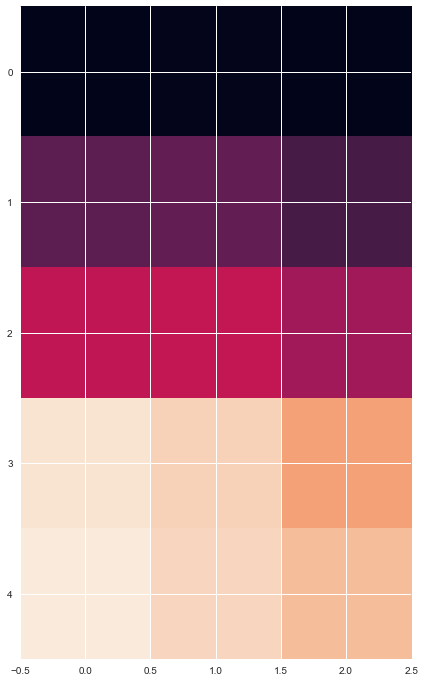

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
uniform_data = TfIDF3[:,:,0]
plt.imshow(uniform_data)
plt.show()